In [1]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
import os
import numpy as np
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
data_dir = '/home/daviesb/Downloads/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [3]:
f = open(fname)
data = f.read()
f.close()

In [4]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [5]:
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [6]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

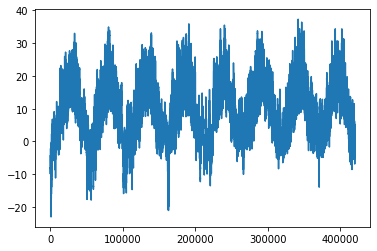

In [7]:
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

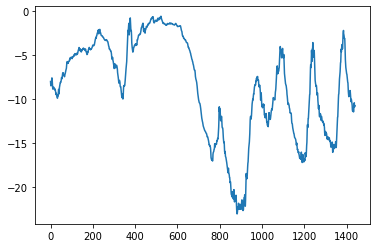

In [8]:
plt.plot(range(1440), temp[:1440])

In [9]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [10]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
            
        yield samples, targets

In [11]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [12]:
train_gen = generator(data=float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=0,
                     max_index=200000,
                     shuffle=True,
                     step=step,
                     batch_size=batch_size)

In [13]:
val_gen = generator(data=float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=200001,
                     max_index=300000,
                     step=step,
                     batch_size=batch_size)

In [14]:
test_gen = generator(data=float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

In [15]:
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [16]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [17]:
evaluate_naive_method()

0.2897359729905486


In [19]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [20]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=20,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 9s 18ms/step - loss: 1.5220 - val_loss: 0.9047
Epoch 2/20
500/500 [==============================] - 8s 17ms/step - loss: 0.5406 - val_loss: 0.2915
Epoch 3/20
500/500 [==============================] - 8s 16ms/step - loss: 0.3067 - val_loss: 0.2633
Epoch 4/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2745 - val_loss: 0.2192
Epoch 5/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2583 - val_loss: 0.1764
Epoch 6/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2464 - val_loss: 0.1916
Epoch 7/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2391 - val_loss: 0.1398
Epoch 8/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2330 - val_loss: 0.2667
Epoch 9/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2286 - val_loss: 0.2249
Epoch 10/20
500/500 [==============================] - 8s 16ms/step - loss: 0.2235 - val_lo

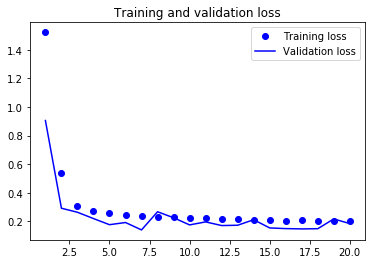

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [19]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 95s 190ms/step - loss: 0.3060 - val_loss: 0.1172
Epoch 2/20
500/500 [==============================] - 91s 182ms/step - loss: 0.2836 - val_loss: 0.1053
Epoch 3/20
500/500 [==============================] - 91s 182ms/step - loss: 0.2758 - val_loss: 0.1246
Epoch 4/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2731 - val_loss: 0.1403
Epoch 5/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2687 - val_loss: 0.1432
Epoch 6/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2647 - val_loss: 0.1301
Epoch 7/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2584 - val_loss: 0.1181
Epoch 8/20
500/500 [==============================] - 91s 183ms/step - loss: 0.2534 - val_loss: 0.1384
Epoch 9/20
500/500 [==============================] - 94s 187ms/step - loss: 0.2510 - val_loss: 0.0992
Epoch 10/20
500/500 [==============================] - 91s 183ms/step - l

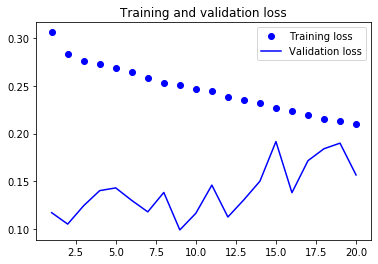

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [19]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                             steps_per_epoch=500,
                             epochs=40,
                             validation_data=val_gen,
                             validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 101s 202ms/step - loss: 211531000984360583168.0000 - val_loss: 0.5442
Epoch 2/40
500/500 [==============================] - 100s 201ms/step - loss: 216768992012470386688.0000 - val_loss: 0.4737
Epoch 3/40
500/500 [==============================] - 99s 199ms/step - loss: 212490194882136342528.0000 - val_loss: 0.4569
Epoch 4/40
500/500 [==============================] - 101s 203ms/step - loss: 216167727386152042496.0000 - val_loss: 0.4162
Epoch 5/40
500/500 [==============================] - 101s 202ms/step - loss: 218478399806676697088.0000 - val_loss: 0.4281
Epoch 6/40
500/500 [==============================] - 100s 200ms/step - loss: 211019189818124402688.0000 - val_loss: 0.4447
Epoch 7/40
500/500 [==============================] - 100s 201ms/step - loss: 206461800503024418816.0000 - val_loss: 0.4533
Epoch 8/40
500/500 [==============================] - 110s 220ms/step - loss: 209560755523329425408.0000 - val_loss: 0.4344
Epoch 9/4

KeyboardInterrupt: 